AINHOA GALLEGO - CNNLSTM 30-64

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
#!pip install keras
from statsmodels.tsa.seasonal import seasonal_decompose
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#!pip install keras --user
#!pip install tensorflow --user
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
#!pip install tensorflow --user
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten

In [ ]:
df = pd.read_csv('ANA.MC2015.csv')

# Convertimos la columna Date en un objeto datetime
df['Date'] = pd.to_datetime(df['Date'])
# Agregamos columnas de año, mes y día
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday  # Monday: 0, Sunday: 6 aunque no existen datos de fin de semana, la bolsa está cerrado; asi que es 0-4 de lunes-viernes

# Calcular el rendimiento diario
df['Return'] = df['Close'].pct_change()
df['Return'].fillna(0, inplace=True)

In [ ]:
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Return']
# eliminamos los datos nulos
df = df.dropna()

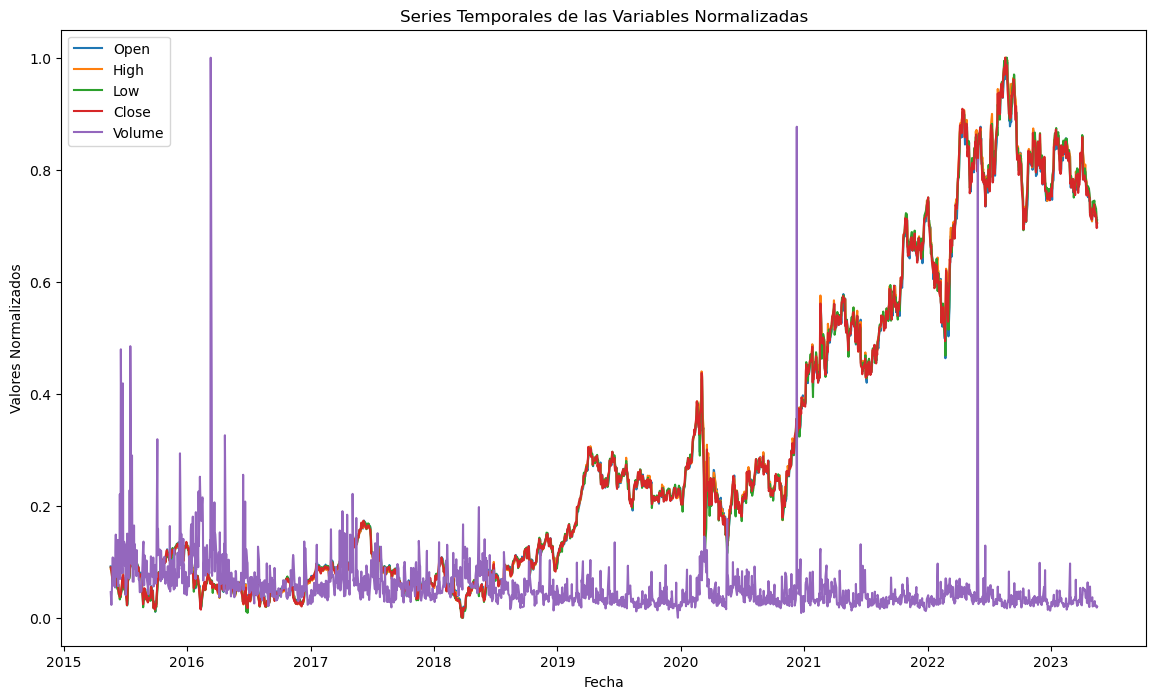

In [ ]:
# Definir las columnas que quieres representar
selected_cols = [col for col in num_cols if col != 'Return']

# Normalizar las columnas numéricas
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df[selected_cols]), columns=selected_cols)

# Agregar la columna 'Date' al dataframe normalizado
scaled_df['Date'] = df['Date']

# Graficar las series temporales de las variables normalizadas
plt.figure(figsize=(14,8))

for column in selected_cols:
    plt.plot(scaled_df['Date'], scaled_df[column], label=column)

plt.xlabel('Fecha')
plt.ylabel('Valores Normalizados')
plt.title('Series Temporales de las Variables Normalizadas')
plt.legend()
plt.show()

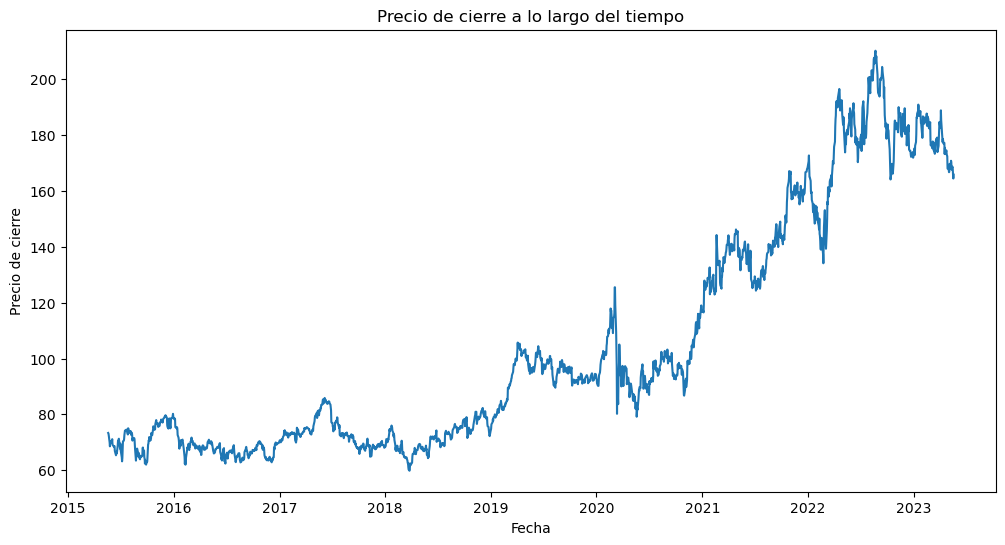

In [ ]:
#VAMOS A MOSTRAT ESTO
# Gráficas de las series temporales
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'])
plt.title('Precio de cierre a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.show()

## MODELO

In [ ]:
## diseñamos una CNN-LSTM
# Seleccionamos las columnas 'Close' y 'Volume'
data = df[['Close', 'Volume']].values

# Normalizamos los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaler_close = MinMaxScaler()
scaler_close.fit(data[:, 0].reshape(-1, 1))

# Dividimos los datos en entrenamiento y prueba
train_size = int(len(scaled_data) * 0.6) #cambiar pot 70/30 (TODOS)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# Función para crear el dataset de entrenamiento
def create_dataset(dataset, look_back=1, look_forward=5):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_forward):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        b = [dataset[i + j, 0] for j in range(look_back, look_back + look_forward)]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

# Creamos el dataset de entrenamiento
look_back = 30 #mismo 30,60,90
look_forward = 1
X_train, y_train = create_dataset(train, look_back, look_forward)

# Creamos el dataset de prueba
X_test, y_test = create_dataset(test, look_back, look_forward)

# Convertimos los datos a arreglos de numpy
X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[2]))

## Modelo de CNN-LSTM, aqui estas creando la estructura del modelo
# Definimos el modelo
model = Sequential()

#esperar confrimacion para este
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(look_back, X_train.shape[2]))) #METEMOS AQUI CNN
model.add(MaxPooling1D(pool_size=2)) #reduce la dimenasionalidad
model.add(Flatten())
model.add(Reshape((X_train.shape[1], -1)))
model.add(LSTM(64)) #aqui 16,32,64
model.add(Dense(look_forward))
model.compile(optimizer='adam', loss='mean_squared_error')

from keras.callbacks import EarlyStopping
# simple early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1)

# Entrenamos el modelo
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, callbacks=[es]) #batch 16 y epoch 50

# Hacemos las predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertimos las predicciones
train_predict = scaler_close.inverse_transform(train_predict)
y_train = scaler_close.inverse_transform(y_train)
test_predict = scaler_close.inverse_transform(test_predict)
y_test = scaler_close.inverse_transform(y_test)

In [ ]:
# Cálculo de métricas de error
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return [rmse, mae, r2]

metrics_train = calc_metrics(y_train, train_predict)
metrics_test = calc_metrics(y_test, test_predict)

metrics_df = pd.DataFrame(index=['RMSE', 'MAE', 'R2'], columns=['Train', 'Test'])
metrics_df['Train'] = metrics_train
metrics_df['Test'] = metrics_test

print(metrics_df)

         Train      Test
RMSE  2.346815  5.786575
MAE   1.768097  4.543230
R2    0.962620  0.971876


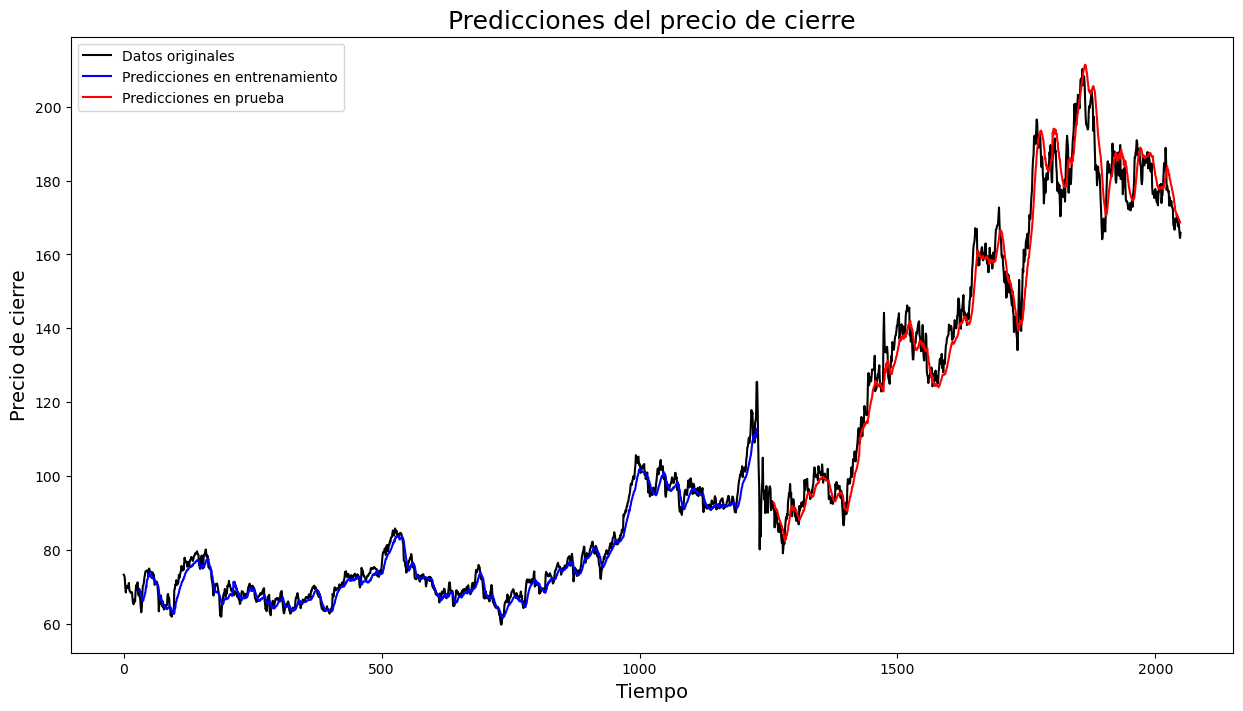

In [ ]:
# Graficamos los datos
plt.figure(figsize=(15,8))


# Graficamos los datos originales
plt.plot(scaler_close.inverse_transform(scaled_data[:, 0].reshape(-1, 1)), color='black', label='Datos originales')
# Graficamos las predicciones de entrenamiento
plt.plot(range(look_back, len(train_predict) + look_back),
         np.array([x[0] for x in train_predict]), color='blue', label='Predicciones en entrenamiento')

# Graficamos las predicciones de prueba
plt.plot(range(len(train_predict) + look_back*2 + look_forward, len(scaled_data) - look_forward),
         np.array([x[0] for x in test_predict]), color='red', label='Predicciones en prueba')

plt.xlabel('Tiempo', fontsize=14)
plt.ylabel('Precio de cierre', fontsize=14)
plt.title('Predicciones del precio de cierre', fontsize=18)

plt.legend()
plt.show()

In [ ]:
#TODAVIA ESTO BO LO CORRO
# Convertir los arrays de NumPy a DataFrames de pandas
real_data_df = pd.DataFrame(np.concatenate((y_train, y_test)), columns=['Real_Data'])

# Extender 'train_predict' con NaNs para que coincida con la longitud de 'real_data'
train_predict_extended = np.concatenate((train_predict, [np.nan]*len(y_test)))
train_predict_df = pd.DataFrame(train_predict_extended, columns=['Train_Fit'])

# Extender 'test_predict' con NaNs al principio para que coincida con la longitud de 'real_data'
test_predict_extended = np.concatenate(([np.nan]*len(y_train), test_predict))
test_predict_df = pd.DataFrame(test_predict_extended, columns=['Test_Predictions'])

# Concatenar estos DataFrames a lo largo del eje de las columnas
result_df = pd.concat([real_data_df, train_predict_df, test_predict_df], axis=1)

# Guardar el DataFrame resultante en un archivo .csv
result_df.to_csv('predictions.csv', index=False)